In [180]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from zipfile import ZipFile
from functools import reduce

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
!pip install -q gdown httpimport
!gdown 'https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip'

In [306]:
zip_file = ZipFile('./2022.11.07-merged-single-observation.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv') and not text_file.filename[37:].startswith('.')}

df_list=[]
for df in dfs.values():
       df['DATE'] = pd.to_datetime(df['DATE'],dayfirst = True)
       df_list.append(df)

df = reduce(lambda left,right: pd.merge(left.drop_duplicates(subset=['DATE','DEPTH']),right.drop_duplicates(subset=['DATE','DEPTH']),on=['DATE','DEPTH'],how='outer'), df_list)
# df.to_csv('xxxxx.csv')
# df.head

In [322]:
# Fill in missing data
for i in df.columns:
    df[i].fillna(df[i].mean(), inplace=True)

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_16604/76482008.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})


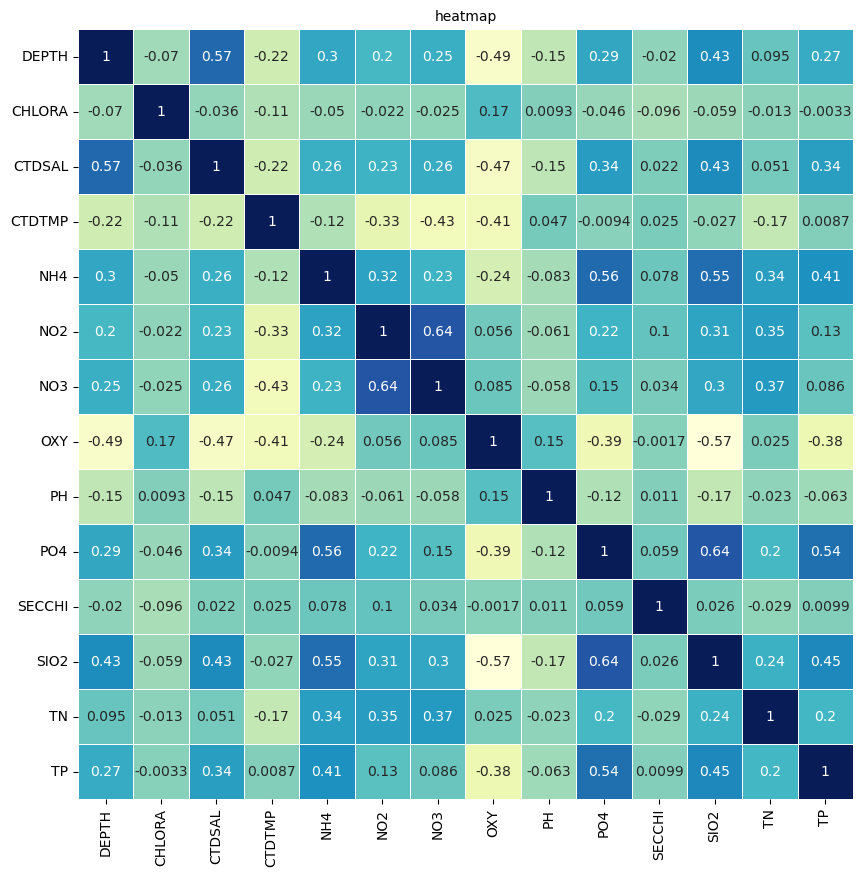

In [323]:
df.dropna(inplace=True)
fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('heatmap',fontsize=10)
plt.show()

In [334]:
X = df.drop(['DATE','OXY','TP','NO2'],axis=1)
y = df[['OXY','TP','NO2']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
x_train['PO4']  = x_train['PO4'] * 0.5
x_train['TP']  = x_train['TP'] * 0.5
x_train['TN']  = x_train['TN'] * 0.5
x_train['SIO2']  = x_train['SIO2'] * 0.8

In [335]:
scaler = StandardScaler(with_mean = True, with_std = True)
scaler.fit(x_train)
norm_X = scaler.transform(x_train)
norm_X_test = scaler.transform(x_test)

In [336]:
# linear regression
lg = LinearRegression()
lg.fit(norm_X, y_train)
y_pred = lg.predict(norm_X_test)
print(mean_squared_error(y_test,y_pred))

1037.6171956474057


In [330]:
# neural netword
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(2,2), solver='sgd', max_iter=3000)
mlp.fit(norm_X,y_train)
y_pred = mlp.predict(norm_X_test)
print(mean_squared_error(y_test, y_pred))

1406.9845994318366


In [337]:
# random forest 
rfr = RandomForestRegressor(random_state=0)
rfr.fit(norm_X, y_train)
y_pred = rfr.predict(norm_X_test)
print(mean_squared_error(y_test, y_pred))

701.6051720843822


1 SIO2 0.3678127716757857
2 CTDTMP 0.2664507524219133
3 DEPTH 0.1315719498516309
4 CTDSAL 0.09407063282013446
5 PO4 0.0367760288247355
6 CHLORA 0.028159233972939925
7 SECCHI 0.019082308583645135
8 NH4 0.01677916776096375
9 NO3 0.016105966629899666
10 TN 0.015125593901954202


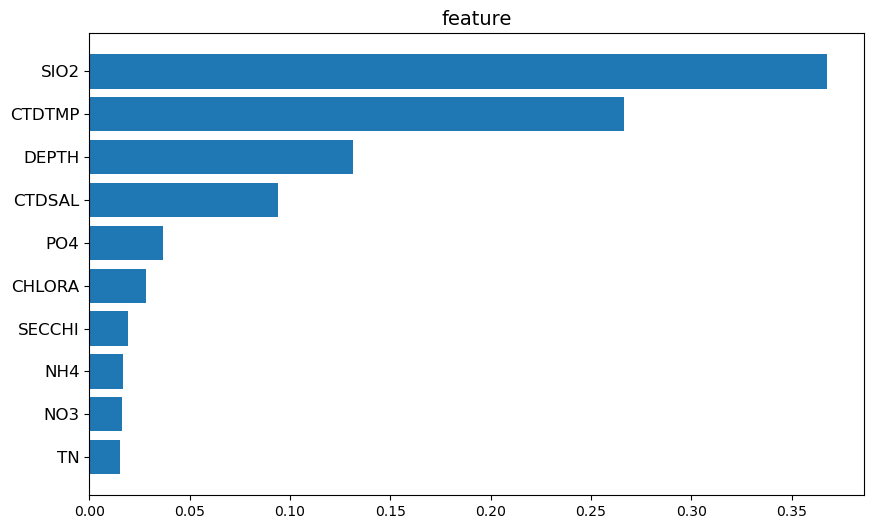

In [338]:
feat_lebels = x_train.columns[0:]
importances  = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
index_list = []
value_list = []
for i,j in zip(range(x_train.shape[1]-1),indices):
    index_list.append(feat_lebels[j])
    value_list.append(importances[j])
    print(i+1, feat_lebels[j], importances[j])

plt.figure(figsize=(10,6))
plt.barh(index_list[::-1],value_list[::-1])
plt.yticks(fontsize = 12)
plt.title('feature',fontsize = 14)
plt.show()

In [339]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[150,200,300],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3]
}
grid_seach_rf= GridSearchCV(estimator=RandomForestRegressor(random_state=0),param_grid=param_grid, scoring='neg_mean_squared_error', cv = 5)
grid_seach_rf.fit(norm_X, y_train)
print(grid_seach_rf.best_params_)

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [342]:
rfr_ = RandomForestRegressor(n_estimators=300, min_samples_leaf=1, min_samples_split=2, random_state=0)
rfr_.fit(norm_X, y_train)
y_pred = rfr_.predict(norm_X_test)
print(mean_squared_error(y_test, y_pred))

698.0916599767924


In [356]:
df_y_pred = pd.DataFrame(y_pred[-50:], index=range(50), columns=['OXY','TP','NO2'])
df_y_pred.head

<bound method NDFrame.head of            OXY        TP       NO2
0   336.410195  1.067823  0.173100
1   311.844417  1.213044  0.541176
2    22.611659  6.314970  0.379334
3   315.354601  1.294151  0.460980
4   322.159833  1.010752  0.254901
5   323.898908  0.683117  0.097835
6   228.354036  0.868724  0.251697
7    93.573593  2.060255  0.356574
8   289.595233  1.251253  0.509745
9   259.631064  1.351932  0.238667
10  262.415418  1.139613  0.099688
11  389.773475  1.008957  0.558830
12  245.090217  1.347826  0.317538
13  290.271200  1.169236  0.241743
14  151.012389  1.189990  0.249381
15  293.666971  0.618766  0.216664
16  122.359742  2.299764  0.251705
17  365.823342  0.968786  0.093904
18  154.134908  0.994603  0.119927
19  373.641183  0.666956  0.053990
20  275.802624  1.485919  0.284480
21  179.959008  1.933487  0.390139
22  302.089493  0.786457  0.187209
23  403.738975  1.321276  0.258497
24  288.587563  1.088465  0.284173
25  338.496114  0.984572  0.434010
26  175.120342  1.309765 

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_16604/3795815089.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(x_,y_test['OXY'][-50:], label = 'oxy_test')


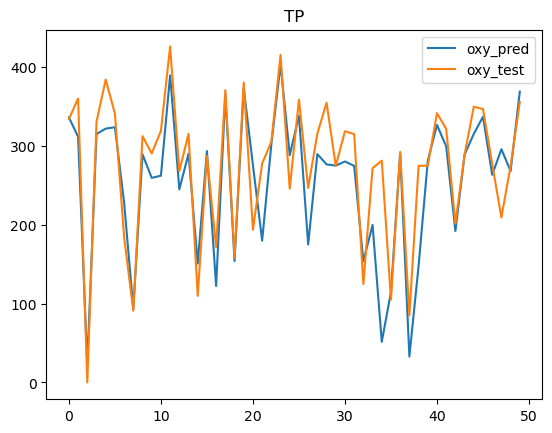

In [358]:
x_ = np.arange(50)
plt.plot(x_, df_y_pred['OXY'], label = 'oxy_pred')
plt.plot(x_,y_test['OXY'][-50:], label = 'oxy_test')
plt.title('TP')
plt.legend()
plt.show()